In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from skimage.transform import resize

In [2]:
import numpy as np
images = np.load("/Users/sreyakaruturi/Downloads/Project/images.npy", allow_pickle=True)
masks = np.load("/Users/sreyakaruturi/Downloads/Project/masks.npy", allow_pickle=True)
labels = np.load("/Users/sreyakaruturi/Downloads/Project//labels.npy")
integer_to_class = {1: 'meningioma', 2: 'glioma', 3: 'pituitary tumor'}

print(f"images:{images.shape}, \
masks:{masks.shape}, \
labels:{labels.shape}")

images:(3064,), masks:(3064,), labels:(3064,)


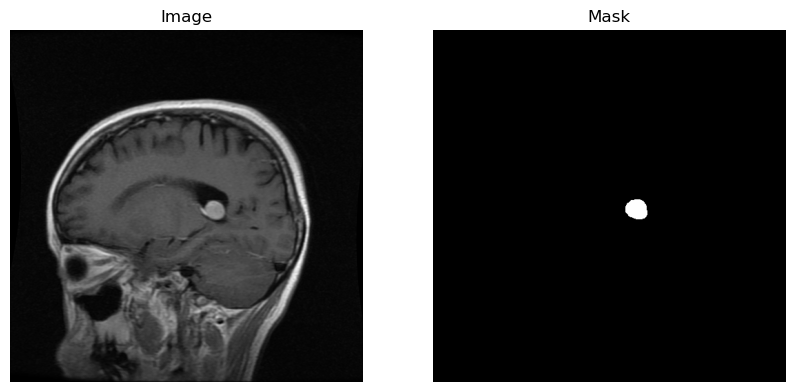

In [5]:
import matplotlib.pyplot as plt
def display_sample(data, index):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(data['images'][index], cmap='gray')
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(data['masks'][index], cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    plt.show()

# Display a sample to verify
display_sample({'images': images, 'masks': masks}, index=0)

In [6]:
from skimage.transform import resize
def preprocess_images(images, masks, target_shape=(256, 256)):
    processed_images = np.array([resize(img, target_shape, preserve_range=True) for img in images])
    processed_masks = np.array([resize(mask, target_shape, mode='constant', anti_aliasing=False) for mask in masks])

    # Normalize images
    processed_images = processed_images.astype('float32') / 255.0

    return processed_images, processed_masks

images_processed, masks_processed = preprocess_images(images, masks)


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images_processed, masks_processed, test_size=0.2, random_state=42)

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout

def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    # Bottleneck
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    
    # Upsampling
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c1])
    c6 = Conv2D(16, (3, 3), activation='relu', padding='same')(u6)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c6)
    model = Model(inputs, outputs)
    return model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         4640      ['max_pooling2d[0][0]']   

In [9]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=8, epochs=20)

Epoch 1/20
307/307 [==============================] - 61s 196ms/step - loss: 0.1202 - accuracy: 0.9784 - val_loss: 0.0778 - val_accuracy: 0.9831
Epoch 2/20
307/307 [==============================] - 61s 199ms/step - loss: 0.0719 - accuracy: 0.9831 - val_loss: 0.0704 - val_accuracy: 0.9831
Epoch 3/20
307/307 [==============================] - 62s 201ms/step - loss: 0.0711 - accuracy: 0.9831 - val_loss: 0.0731 - val_accuracy: 0.9831
Epoch 4/20
307/307 [==============================] - 65s 213ms/step - loss: 0.0707 - accuracy: 0.9831 - val_loss: 0.0697 - val_accuracy: 0.9831
Epoch 5/20
307/307 [==============================] - 62s 202ms/step - loss: 0.0702 - accuracy: 0.9831 - val_loss: 0.0698 - val_accuracy: 0.9831
Epoch 6/20
307/307 [==============================] - 62s 202ms/step - loss: 0.0700 - accuracy: 0.9831 - val_loss: 0.0691 - val_accuracy: 0.9831
Epoch 7/20
307/307 [==============================] - 62s 202ms/step - loss: 0.0696 - accuracy: 0.9831 - val_loss: 0.0693 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


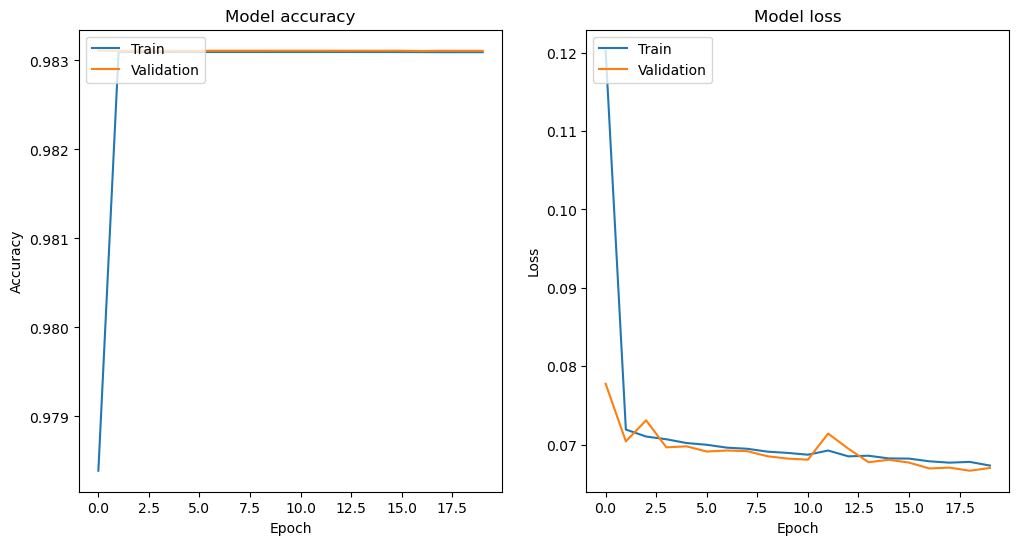

In [13]:
import matplotlib.pyplot as plt
print(history.history.keys())
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()
if 'dice_coefficient' in history.history:
    plt.figure(figsize=(6, 5))
    plt.plot(history.history['dice_coefficient'])
    plt.plot(history.history['val_dice_coefficient'])
    plt.title('Model Dice Coefficient')
    plt.ylabel('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [14]:
loss, accuracy = model.evaluate(X_val, y_val)
print("Validation accuracy:", accuracy)
predictions = model.predict(X_val)

20/20 [==============================] - 7s 328ms/step - loss: 0.0670 - accuracy: 0.9831
Validation accuracy: 0.9831079840660095
20/20 [==============================] - 6s 296ms/step


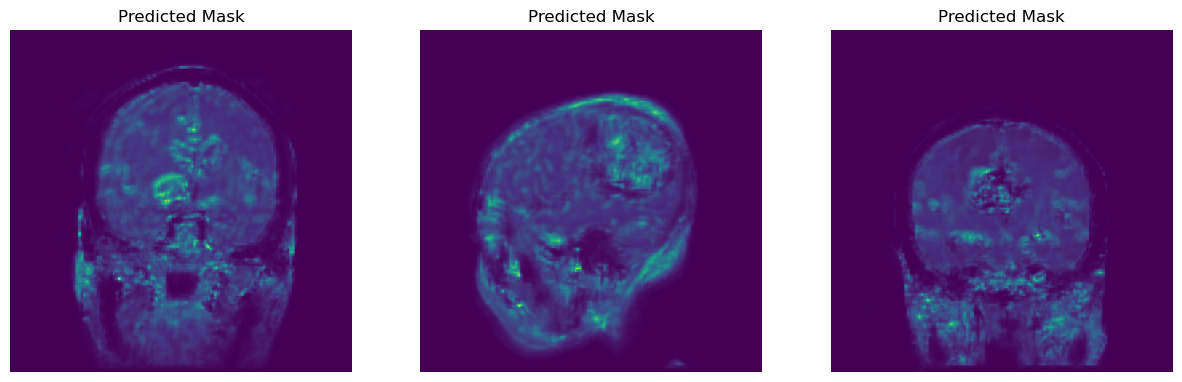

In [17]:
def display_comparison(indices):
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        plt.subplot(1, len(indices), i+1)
        plt.imshow(np.squeeze(predictions[idx]), cmap='viridis')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()
display_comparison([0, 1, 2]) 

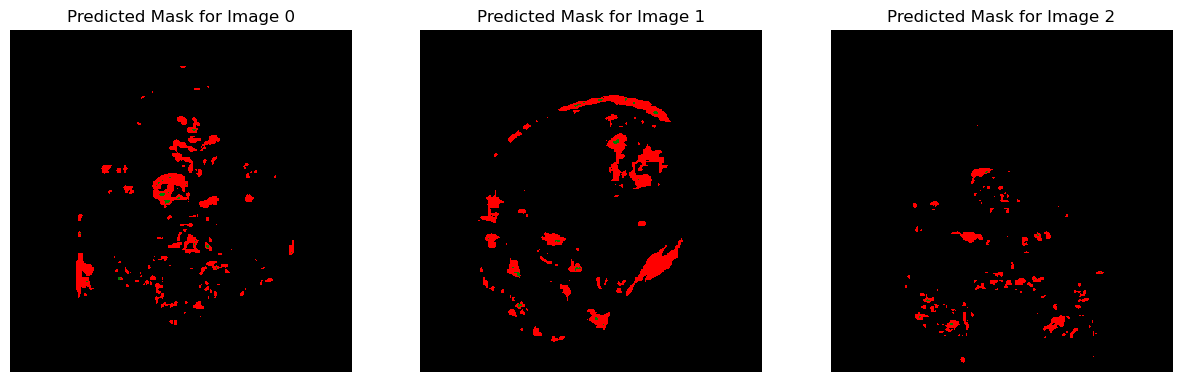

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
colors = ['black', 'red', 'green']  # Add more colors if there are more classes
cmap = ListedColormap(colors)

def display_comparison(predictions, indices):
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, len(indices), i+1)
        plt.imshow(np.squeeze(predictions[idx]), cmap=cmap)
        plt.title(f'Predicted Mask for Image {idx}')
        plt.axis('off')
    plt.show()
display_comparison(predictions, [0, 1, 2])


In [27]:
predicted_masks = model.predict(X_val)

20/20 [==============================] - 6s 290ms/step


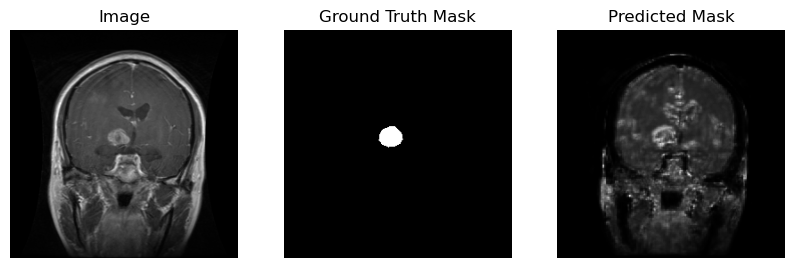

In [28]:
def display_predicted_masks(images, masks, predicted_masks, index):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(images[index], cmap='gray')
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(masks[index], cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_masks[index].reshape(256, 256), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

# Display a sample of predicted masks on original images
display_predicted_masks(X_val, y_val, predicted_masks, index=0)

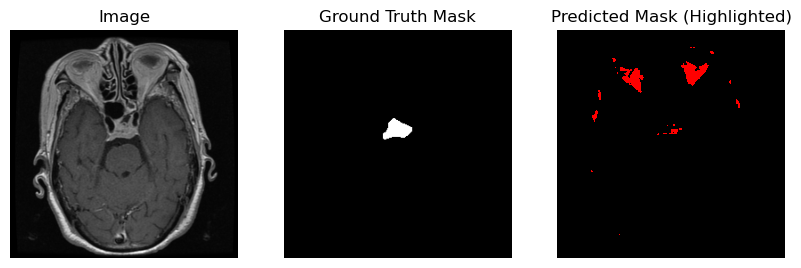

In [38]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['black', 'red'])  

def display_predicted_masks(images, masks, predicted_masks, index):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(images[index], cmap='gray')
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(masks[index], cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_masks[index].reshape(256, 256), cmap=cmap)
    plt.title('Predicted Mask (Highlighted)')
    plt.axis('off')

    plt.show()
display_predicted_masks(X_val, y_val, predicted_masks, index=150)
